In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
from matplotlib import cm
from torch.utils.data import Dataset, DataLoader
%matplotlib inline

In [2]:
all_data_files = glob('./data/*.pkl')

In [29]:
def clean_data(data):
    data[data == -1] = 0
    data[143:167, 223:247][data[143:167, 223:247] == 0] = 1
    return data 

def resize_data(data):
    im = Image.fromarray(np.uint8(cm.gist_earth(data, alpha=None)*255)[:, :, :3])
    resized_data = np.array(im.resize((112, 76)).convert('L'))
    return resized_data/resized_data.max()


class SeaIceDataset(Dataset):
    
    def __init__(self, seq_len, data_folder='./data/*.pkl'):
        self.seq_len = seq_len
        self.data_files = glob(data_folder)
        
    def __len__(self):
        return len(self.data_files) - (self.seq_len + 1)
    
    def __getitem__(self, ix):
        X = np.array([resize_data(clean_data(np.array(np.load(d)))).flatten() for d in self.data_files[ix:ix+self.seq_len]])
        y = resize_data(clean_data(np.load(self.data_files[ix+self.seq_len+1]))).flatten()
        return X, y
    
# class SeaIceDataset(Dataset):
    
#     def __init__(self, seq_len, data_folder='./data/*.pkl'):
#         self.seq_len = seq_len
#         self.data_files = glob(data_folder)
        
#     def __len__(self):
#         return len(self.data_files) - (self.seq_len + 1)
    
#     def __getitem__(self, ix):
#         X = np.array([clean_data(np.array(np.load(d))).flatten() for d in self.data_files[ix:ix+self.seq_len]])
#         y = clean_data(np.load(self.data_files[ix+self.seq_len+1])).flatten()
#         return X, y
    
final = resize_data(clean_data(np.load(all_data_files[-1]))).flatten()
dataset = SeaIceDataset(3)
assert(np.allclose(final, dataset[len(dataset)-1][1]))

# Visualize some resized examples

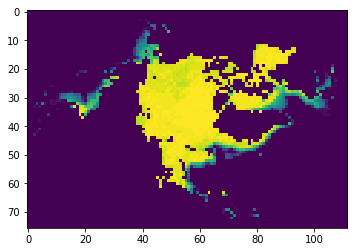

In [30]:
plt.imshow(resize_data(clean_data(np.load(all_data_files[3]))))

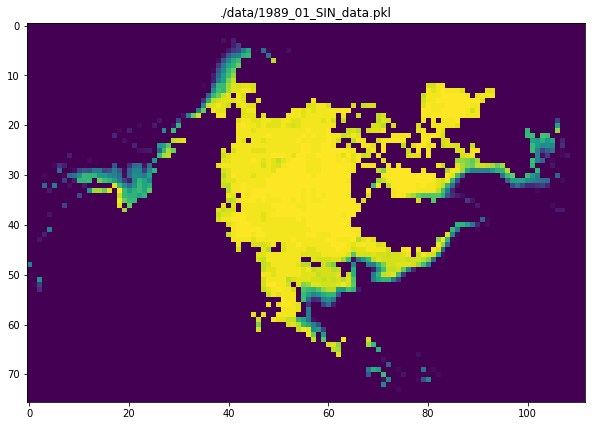

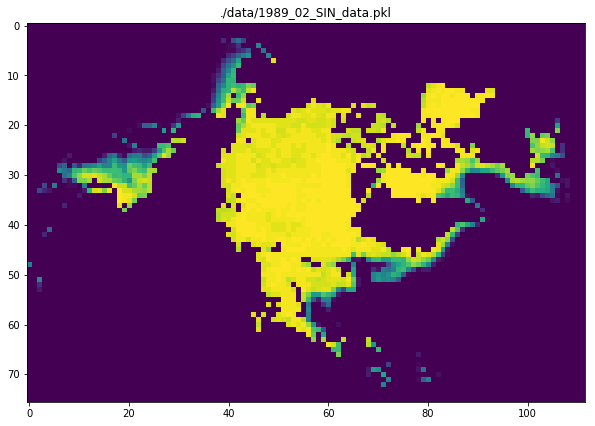

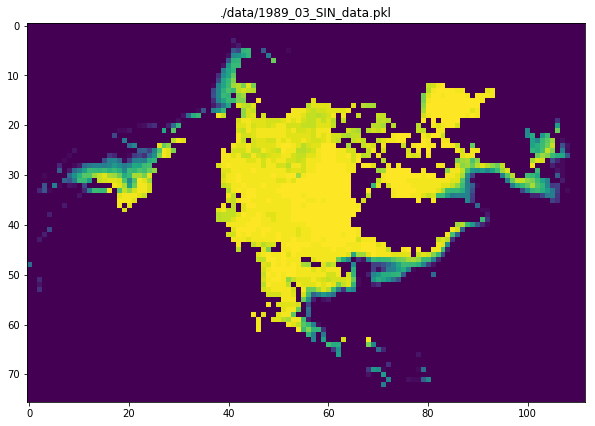

In [31]:
seqs = []
for d in all_data_files[:3]:
    data = clean_data(np.load(d))
    plt.figure(figsize=(10,10))
    plt.title(d)
    plt.imshow(resize_data(data))
    seqs.append(resize_data(data).flatten())

# Examining input data in context of LSTM

In [6]:
W, H = 304, 448

In [7]:
KS = 3
P = 1
S = 1

In [8]:
new_width = ((W - KS + (2*P))/S) + 1
new_width

304.0

In [1]:
9*14

126

In [50]:
class ConvBlock(torch.nn.Module):
    
    def __init__(self):
        super(ConvBlock, self).__init__()
        self.conv_block = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2), # 152
            torch.nn.Conv2d(16, 8, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2), # 76
            torch.nn.Conv2d(8, 4, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
            torch.nn.Conv2d(4, 1, kernel_size=1),
            torch.nn.ReLU()# 1x38x56
        )
    
    def forward(self, x):
        return self.conv_block(x)

class CustomLSTM(torch.nn.Module):
    
    def __init__(self, num_nets):
        super(CustomLSTM, self).__init__()
        
        self.num_nets = num_nets
        
        # Generate as many convolutional networks as needed.
        self.conv_nets = [ConvBlock() for n in range(self.num_nets)]
        for ix, cn in enumerate(self.conv_nets):
            self.add_module('conv{}'.format(ix+1), cn)
        
        self.seq_length = 3
        self.num_layers = 1
        self.batch_size = 8
        self.hidden_dim = 8512
        self.input_size = 9*14
        
        self.lstm = torch.nn.LSTM(self.input_size, self.hidden_dim, num_layers=self.num_layers, batch_first=True)
        
        self.hidden = self.init_hidden()
        
    def init_hidden(self):
        # This is what we'll initialise our hidden state as
        return (torch.randn(self.num_layers, self.batch_size, self.hidden_dim).cuda(),
                torch.randn(self.num_layers, self.batch_size, self.hidden_dim).cuda())
    
    def forward(self, x):
        # X is (batch, seq, w, h)
        # Run inputs throuh initial neural networks
        x = torch.cat([net(x[:,ix,:].view(-1,1,76,112).type(torch.float32)) for ix, net in enumerate(self.conv_nets)], dim=1).flatten(start_dim=2, end_dim=3)
        
        # Make sequences of data retrieved nuearl network.
        xs = make_seqs(x, self.seq_length, x.shape[0], self.input_size).cuda()
        o, self.hidden = self.lstm(xs, self.hidden)     
        return o

def make_seqs(xs, seq_length, batch_size, input_size):
    return torch.cat((tuple(map(lambda x: torch.tensor(x, dtype=torch.float32), xs)))).view(batch_size, seq_length, input_size)

In [51]:
seq_length = 3
num_layers = 1
batch_size = 8
hidden_dim = 8512
input_size = 9*14     
n_epochs = 50

In [52]:
si_dataset = SeaIceDataset(seq_length)
dl = DataLoader(si_dataset, shuffle=True, batch_size=batch_size, num_workers=3)

model = CustomLSTM(3).cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
criterion = torch.nn.BCE()
dl = DataLoader(si_dataset, shuffle=True, batch_size=batch_size, num_workers=3, drop_last=True)

In [ ]:
for epoch in range(n_epochs):
    print("epoch: {}".format(epoch))
    losses = []
    for ix, (X, y) in enumerate(dl):
        optimizer.zero_grad()

        o = model(X.cuda())
        y = torch.tensor(y, dtype=torch.float).cuda()
        
        loss = criterion(o[:,-1,:], y)
        loss.backward(retain_graph=True)
        losses.append(loss.item())
        optimizer.step()
        del o, y, loss, X
    
    print("loss: {}".format(np.mean(losses)))

epoch: 0


/uufs/chpc.utah.edu/common/home/u0897718/MYTF/lib/python3.6/site-packages/ipykernel_launcher.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/uufs/chpc.utah.edu/common/home/u0897718/MYTF/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


loss: 0.10507817237183105
epoch: 1


In [38]:
for X,y in dl:
    break

In [39]:
pred = model(X.cuda())

/uufs/chpc.utah.edu/common/home/u0897718/MYTF/lib/python3.6/site-packages/ipykernel_launcher.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [40]:
pred.shape

torch.Size([32, 3, 8512])

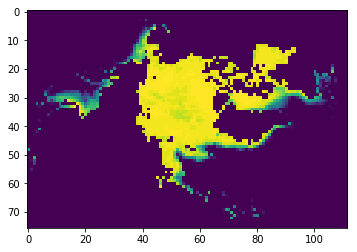

In [41]:
plt.imshow(y[0].detach().numpy().reshape(76, 112))

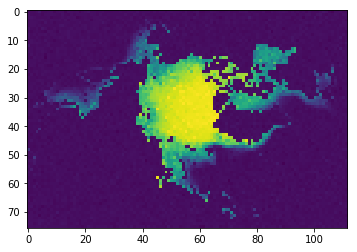

In [43]:
plt.imshow(pred[0,0, :].cpu().detach().numpy().reshape(76, 112))